# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

You can use `pyarabic` or any other library to pre-process and clean the Arabic text.

In [223]:
# pip install pyarabic

# Download the Dataset

Please note that you are allowed to take a subset of this dataset, the reason for that is it might take a long time to train the model on.

In [224]:
# !kaggle datasets download -d khaledzsa/sanad
# !unzip sanad.zip

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarabic.araby as araby
import tensorflow as tf
import nltk

from keras.models import Sequential
from keras.layers import Embedding, Dense, Lambda,Input, Bidirectional, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from collections import Counter

from nltk.corpus import stopwords

from nltk.stem.porter import *

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [226]:
# nltk.download('stopwords')

# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [227]:
df = pd.read_csv('sanad.csv')

In [228]:
df.head()

,text,label
0,https://example.com/resource/الشاٌرقة -ْ محمِد...,Culture
1,https://example.com/resource/اَنِطٌلقّتَ ٍفٍيّ...,Culture
2,https://example.com/resource/أُقيًمٌتِ مِساءُ ...,Culture
3,https://example.com/resource/بٍاسُمةَ يًوٌنٍس ...,Culture
4,https://example.com/resource/قُرر اَتحِاد اًلْ...,Culture


In [229]:
df.tail()

,text,label
39880,https://example.com/resource/أعلّنت شّركٌةً بّ...,Tech
39881,https://example.com/resource/بُتٍاَرٌيًخَ 28ْ ...,Tech
39882,https://example.com/resource/دبَيُ:َ «ُاَلخليج...,Tech
39883,https://example.com/resource/LٌG GًS2ْ9ً0 Coْo...,Tech
39884,https://example.com/resource/تنطًلقٍ اٌليومّ َ...,Tech


In [230]:
df.sample(10)

,text,label
11060,https://example.com/resource/تحًولتُ اُلّتٌحٌر...,Finance
33871,https://example.com/resource/كًتبَت ّصِحيفة «م...,Sports
17690,"https://example.com/resource/دبي - ""ّاَلخٍليًج...",Medical
39146,https://example.com/resource/أعلنَت ٍأْمَس ِشر...,Tech
31584,https://example.com/resource/سْيْنطِلُق ٌالبرَ...,Sports
21766,https://example.com/resource/حمَل حَزْب ٍحٍركٌ...,Politics
7676,https://example.com/resource/شهِد سوُقَ ُدبي ٌ...,Finance
26049,https://example.com/resource/فيٍ أيام الِله ُن...,Religion
9945,https://example.com/resource/أعَادٍ بنكَ اًلٍش...,Finance
36034,https://example.com/resource/أَبًوظبِي:ْ «ٍالُ...,Tech


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39885 entries, 0 to 39884
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39885 non-null  object
 1   label   39885 non-null  object
dtypes: object(2)
memory usage: 623.3+ KB


In [232]:
df.isna().sum()

,0
text,0
label,0


In [233]:
df.duplicated().sum()

0

In [234]:
df.label.value_counts()

,count
label,
Politics,6334
Medical,6292
Culture,6098
Finance,6095
Tech,5979
Sports,5859
Religion,3228


<Axes: ylabel='label'>

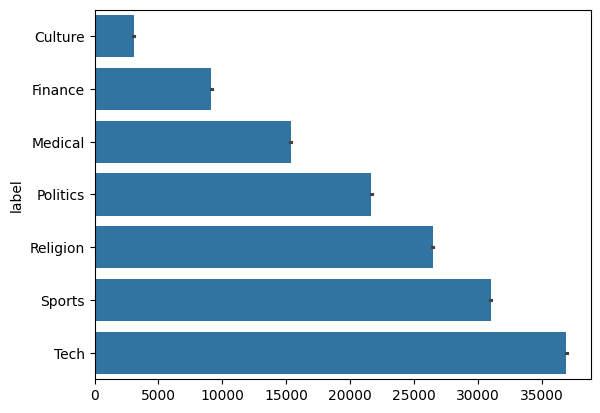

In [235]:
import seaborn as sns
sns.barplot(df["label"])

In [236]:
df['length'] = df['text'].str.len()

In [237]:
df.length.describe()

,length
count,39885.000000
mean,2431.978538
std,1499.160479
min,176.000000
25%,1226.000000
50%,2064.000000
75%,3404.000000
max,7624.000000


<Axes: ylabel='Frequency'>

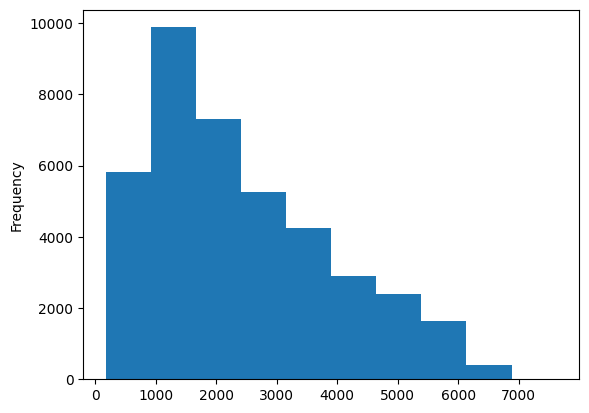

In [238]:
df.length.plot(kind='hist')

<Axes: >

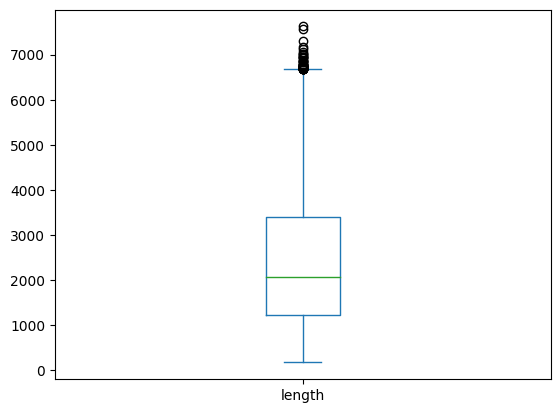

In [239]:
df.length.plot(kind='box')

In [240]:
min_length = 200
max_length = 4000

In [241]:
df[df.length >= max_length]

,text,label,length
0,https://example.com/resource/الشاٌرقة -ْ محمِد...,Culture,5922
5,https://example.com/resource/تتّنٌاّول َاِلِرو...,Culture,5077
9,https://example.com/resource/يختتم فيً تٌمامٌ ...,Culture,4225
12,https://example.com/resource/اٌلشارٍقة:ٍ «ْالٌ...,Culture,4903
17,https://example.com/resource/أٍكد ِحبَيب ّيوسْ...,Culture,4293
...,...,...,...
39856,https://example.com/resource/أطًلقتِ ِالَنيابُ...,Tech,5480
39861,https://example.com/resource/زٍاَرً سّمُوّ ٍال...,Tech,4516
39863,"https://example.com/resource/دٌبّي - ""الَخِلْي...",Tech,5625
39877,https://example.com/resource/أعلٌنت ٌسٌاُمٌسون...,Tech,6184


In [242]:
df[df.length <= min_length]

,text,label,length
924,https://example.com/resource/يُنظمْ َالنادٍي ا...,Culture,196
6208,https://example.com/resource/أًعلنتُ ُشرِكةً ر...,Finance,189
6611,https://example.com/resource/أعٍلنْ ُمجلِس ْإْ...,Finance,188
6895,"https://example.com/resource/دبّي ْ""ِالَخّليٍج...",Finance,187
7104,https://example.com/resource/اَغلق اِلَسلَام ٌ...,Finance,176
7461,https://example.com/resource/قررُ ِمجْلْس إَدا...,Finance,184
7502,https://example.com/resource/أعاد ّبنكً أبَوُظ...,Finance,186
7592,https://example.com/resource/أعلنَ سٌوْق دٌبْي...,Finance,200
7902,https://example.com/resource/أوصت َمجُموٌعةّ ٌ...,Finance,184
8060,https://example.com/resource/حقِقت اِلَعين َاُ...,Finance,177


In [246]:
# token_cnt = Tokenizer()
# token_cnt.fit_on_texts(df['text'])
# x = token_cnt.texts_to_sequences(df['text'])

# cnt = Counter()

# x.apply(cnt.update)

In [247]:
# cnt.most_common(10)

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **Arabic stopwords loading**:
   We load a list of Arabic stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   - **Removing links (URLs)**: Any URLs present in the text are removed as they are not meaningful for classification purposes.
   - **Removing special characters and punctuation**: This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   - **Removing Arabic diacritics (Tashkeel) and elongated letters (Tatweel)**: Diacritical marks and elongated letters are stripped out to standardize the text.
   - **Removing Arabic stopwords**: Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   - **Stemming or Lemmmatization**: Either stemming or lemmatization is applied to reduce words to their root or base form.
   - **Normalizing Hamza**: Any variation of the Hamza character is normalized for consistency.

   **Note:** Most of these you can do using the library [PyArabic](https://pyarabic.readthedocs.io/ar/latest/README.html#features)

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [248]:
# url_pattern = r'https?\S+|www\S+'
# temp = 'http://ffdasfsa.com dfsafsafs'

# re.sub(url_pattern,'',temp)

In [249]:
stopwords_arabic = set(stopwords.words('arabic'))

porter_stem = PorterStemmer()

In [250]:
# stopwords_arabic

In [251]:
# df.dropna(inplace=True)
# df.drop_duplicate(inplace=True)

def text_cleaning(text):
  url_pattern = r'https?\S+|www\S+'
  text = re.sub(url_pattern,'',text)

  text = araby.strip_tashkeel(text)
  text = araby.strip_tatweel(text)

  S_P_pattern = r'[^\w\s]'
  text = re.sub(S_P_pattern,'',text)

  text = text.split()

  new_text = [i for i in text if i not in stopwords_arabic]

  stemmed = [porter_stem.stem(i) for i in new_text]

  text = ' '.join(stemmed)

  text = araby.normalize_hamza(text)

  return text

def data_cleaning(data):
  data = data[(data.length > min_length) & (data.length < max_length)]
  return data


df = data_cleaning(df)
df['text'] = df['text'].apply(text_cleaning)

# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [253]:
df.drop(columns='length',inplace=True)

In [254]:
X_train,X_test,y_train,y_test = train_test_split(df['text'],df['label'],test_size=0.2,random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # needed to be just on the train
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

MAX_LEN = 400

padded_train = pad_sequences(sequences_train,maxlen=MAX_LEN,padding='post')
padded_test = pad_sequences(sequences_test,maxlen=MAX_LEN,padding='post')


# label_encoder = LabelEncoder()

# y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.transform(y_test)

ohe = OneHotEncoder()

y_train = ohe.fit_transform(y_train)
y_test = ohe.transform(y_test)

In [267]:
X_train.shape,y_train.shape

((26372,), (26372,))

In [268]:
X_test.shape,y_test.shape

((6594,), (6594,))

# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [269]:
model = Sequential([
    Input((MAX_LEN,)),
    Embedding(input_dim=len(tokenizer.word_index)+1,output_dim = 64,input_length=MAX_LEN),
    Bidirectional(SimpleRNN(units=64,return_sequences=True)),
    # Bidirectional(SimpleRNN(units=32,return_sequences=True)),

    Bidirectional(SimpleRNN(units=32)),

    Dense(units=32,activation='relu'),
    Dense(units=7,activation='softmax'),
])

In [270]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 400, 64)             │      16,750,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 400, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,779,207 (64.01 MB)

 Trainable params: 16,779,207 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [271]:
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy']) # With label encoding

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) # with one hot encoding

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [272]:
# dataset_train = tf.data.Dataset.from_tensor_slices(sequences_train)

# dataset_train = dataset_train.batch(32)

# dataset_test = tf.data.Dataset.from_tensor_slices(X_test)

# dataset_test = dataset_train.batch(32)

In [276]:
history = model.fit(padded_train,y_train,epochs=5,validation_split=0.2)

Epoch 1/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 622s 750ms/step - accuracy: 0.6017 - loss: 1.0330
Epoch 2/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 647s 781ms/step - accuracy: 0.9681 - loss: 0.1063
Epoch 3/5
 16/825 ━━━━━━━━━━━━━━━━━━━━ 17:23 1s/step - accuracy: 0.9850 - loss: 0.0541

KeyboardInterrupt: 

In [263]:
# history = model.fit(dataset_train,epochs=5) # trying with from_slices from tf

Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1_1/Cast:0", shape=(None, None, None), dtype=float32). Expected shape (None, 400), but input has incompatible shape (None, None, None)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, None), dtype=string)
  • training=True
  • mask=None

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [279]:
print(model.evaluate(padded_test,y_test))

207/207 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.9518 - loss: 0.1716
[0.1713801473379135, 0.950409471988678]


<Axes: >

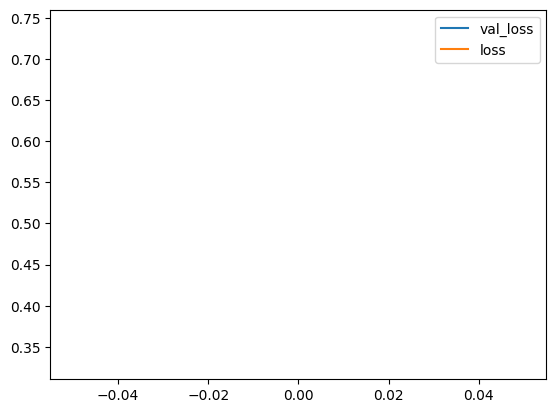

In [282]:
pd.DataFrame(history.history)[['val_loss','loss']].plot() # not showing anything because I stopped the history fitting. if it finished it will give the result, I had it before but I run it again and it dissappear

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [285]:
# test_sample = ['لعب',"لها","السياسة","ممتع"]
test_sample = "الملعب يشعرني بالسعادة"

test_sample = text_cleaning(test_sample)

test_sequence = tokenizer.texts_to_sequences([test_sample])

test_padded = pad_sequences(test_sequence,maxlen=MAX_LEN,padding='post')

prediction = model.predict(test_padded)

prediction_index = np.argmax(prediction)

print(ohe.inverse_transform([prediction_index]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
['Culture']


In [ ]:
# print(tokenizer.texts_to_sequences)
# pad_sequences([tokenizer.texts_to_sequences('الاستفادة الاستفادة الاستفادة')],maxlen=MAX_LEN,padding='post')

# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

#### Preprocessing
- I used the arabic strips to delete some of the arabic language harakat and hamza and others
- I deleted the punctiation and special characters
- Deleted the URLs
- Used Stem to normalize the text

#### Model Design
- I used SimpleRNN because it takes too much time and I needed to make it faster.
- I used Bidirectional to get the sequence feature
- I used 7 as output softmax becuase there are 7 categories in the label


#### Number of Layers
- It's a hyper parameter I tested a few of them but I setteled in the end of what I have. it didn't make much difference

#### Evaluation Methods
- Used Accuracy due to having multiple categories and even they are not distributed well. but still accuracy would be a better metrics due to having 7 categories and not just 2

#### Overfitting | Underfitting
- There is no overfitting or underfitting. I saw the loss curve and there is not much of difference between the validation and train loss

#### Improve model
- Could improve the preprocessing more
- Could add different types of model like LSTM and GRU to check a better model
- Could add more fully connected layers

Resources:
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
- https://www.tensorflow.org/api_docs/python/tf/keras/Model
- https://www.tensorflow.org/api_docs/python/tf/compat/v1/tpu/experimental/embedding
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://www.nltk.org/howto/stem.html
- https://pypi.org/project/PyArabic/
- https://keras.io/api/models/model_training_apis/